In [316]:
# 작업 환경 설정
import matplotlib.dates as md
import pandas as pd
import numpy as np
import math

# 모델 분석
import statsmodels.api as sm
from sklearn.decomposition import PCA

# 시각화
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

from matplotlib import rc

plt.style.use('seaborn')
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [252]:
%matplotlib inline

#### 날씨 데이터 불러오기
- ASOS 관측소의 데이터만 사용
- area 184(제주), 185(고산), 188(성산), 189(서귀포)

In [209]:
weather_df = pd.read_csv("weather_v2.csv")
weather_df = weather_df[weather_df["station"] == "ASOS"]

##### datetime 컬럼을 date와 time으로 나누기

In [210]:
def split_date(data, col):
    date = data[col].str.split(' ').str[0]
    time = data[col].str.split(' ').str[1]
    return date, time

In [211]:
weather_df["date"], weather_df["time"] = split_date(weather_df, "datetime")

##### 날씨 데이터의 36개의 독립변수 중 사용할 독립변수만 추출
- 온도, 풍속, 강수량, 습도(상대) 사용

In [212]:
weather_useful = weather_df[["date", "time", "temp", "ws", "prec", "humid"]]

In [213]:
# 각 독립변수들의 Null값 확인
weather_useful.isnull().sum().sort_values()

date         0
time         0
humid       43
temp        45
ws         505
prec     71820
dtype: int64

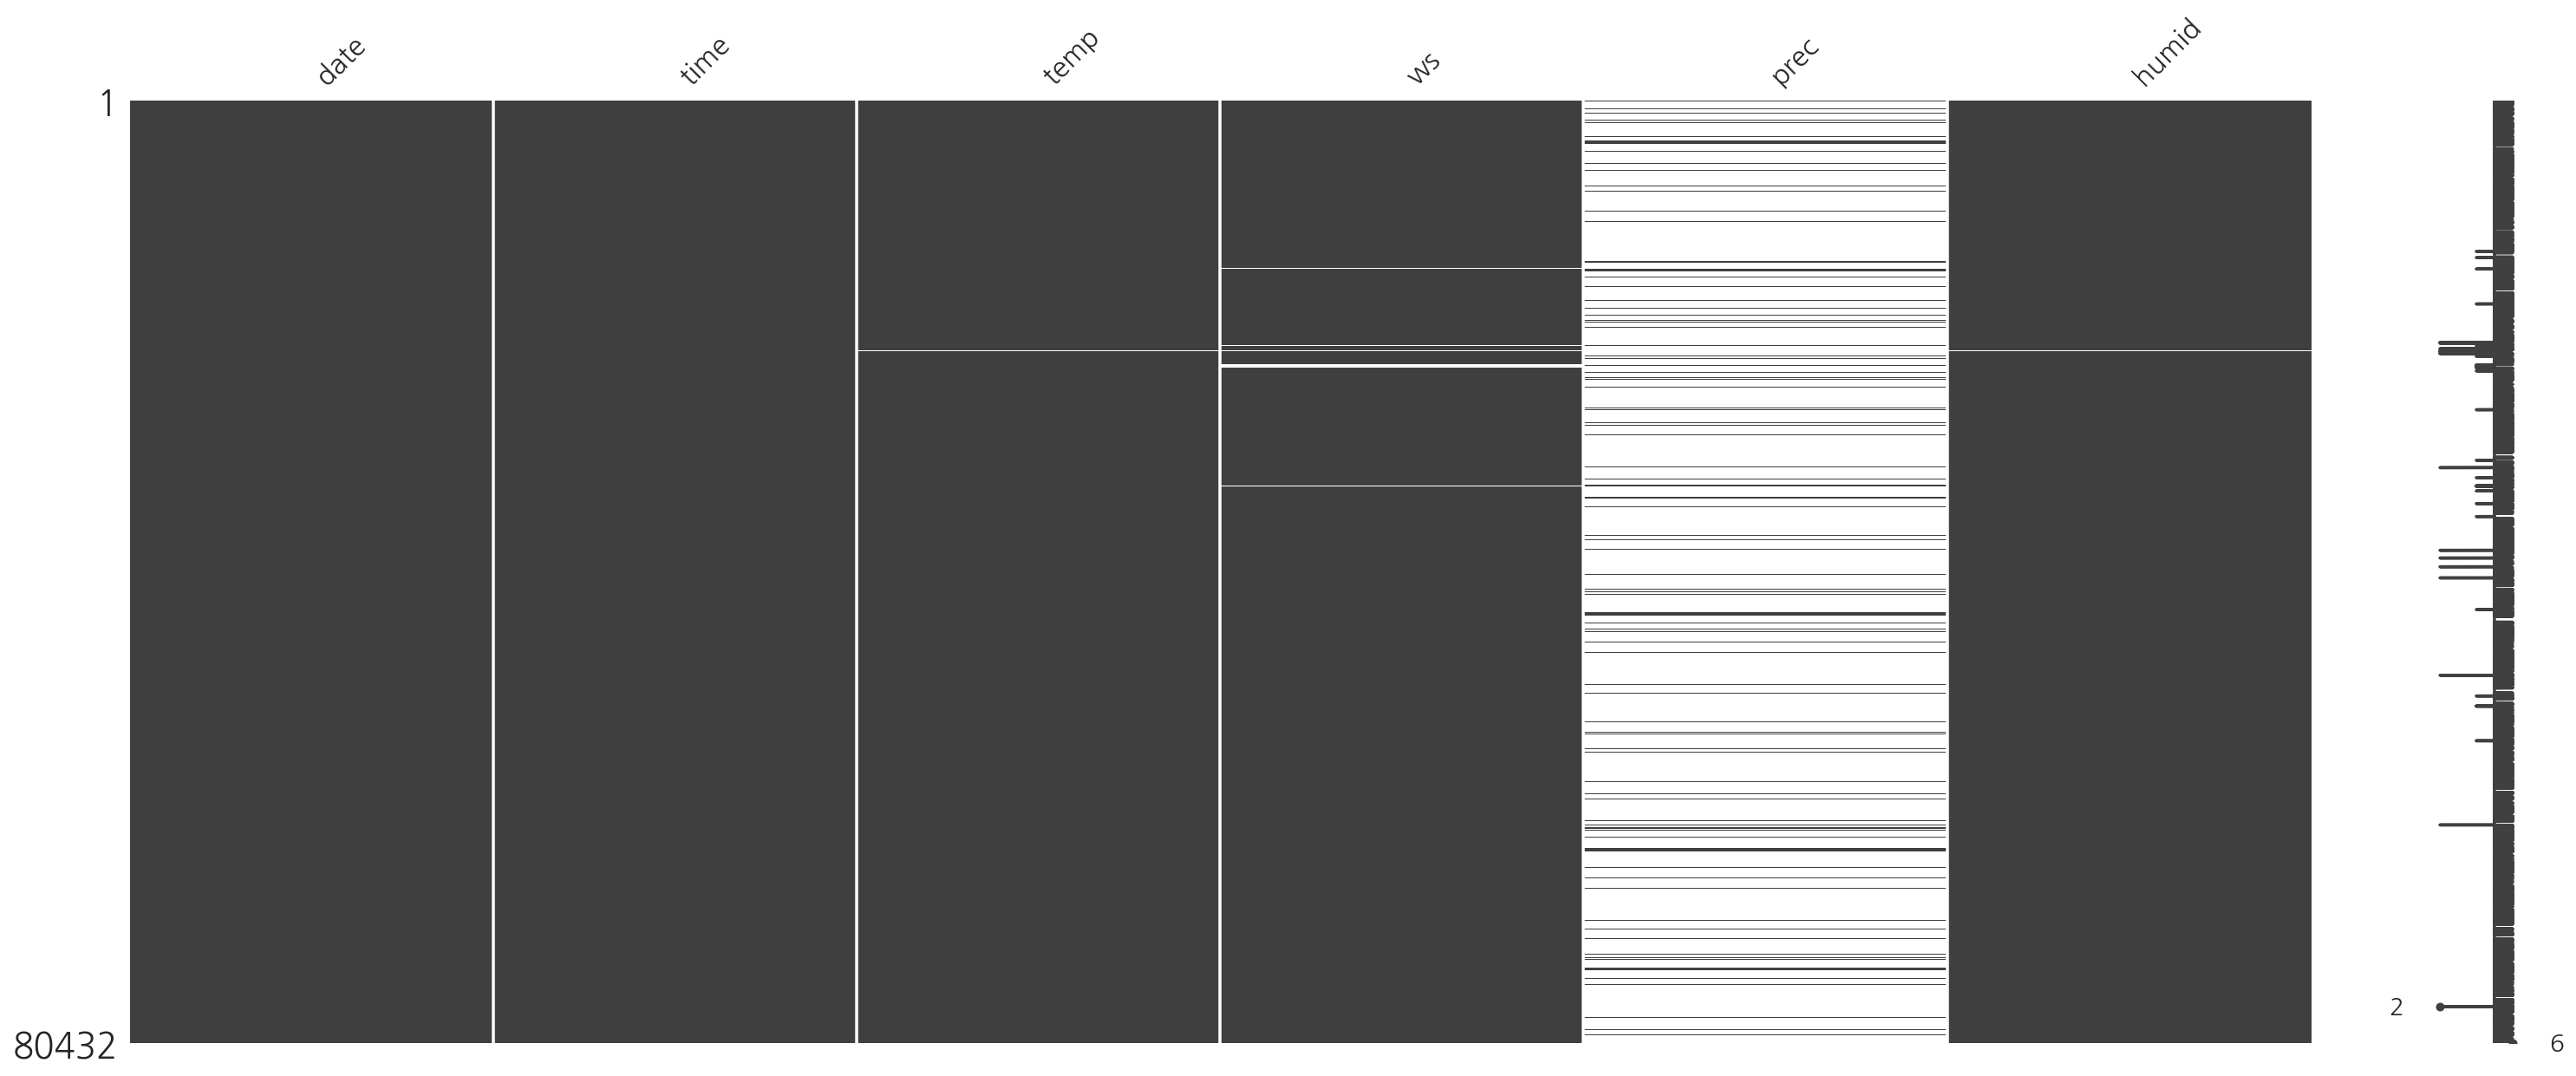

In [214]:
msno.matrix(weather_useful)
plt.show()

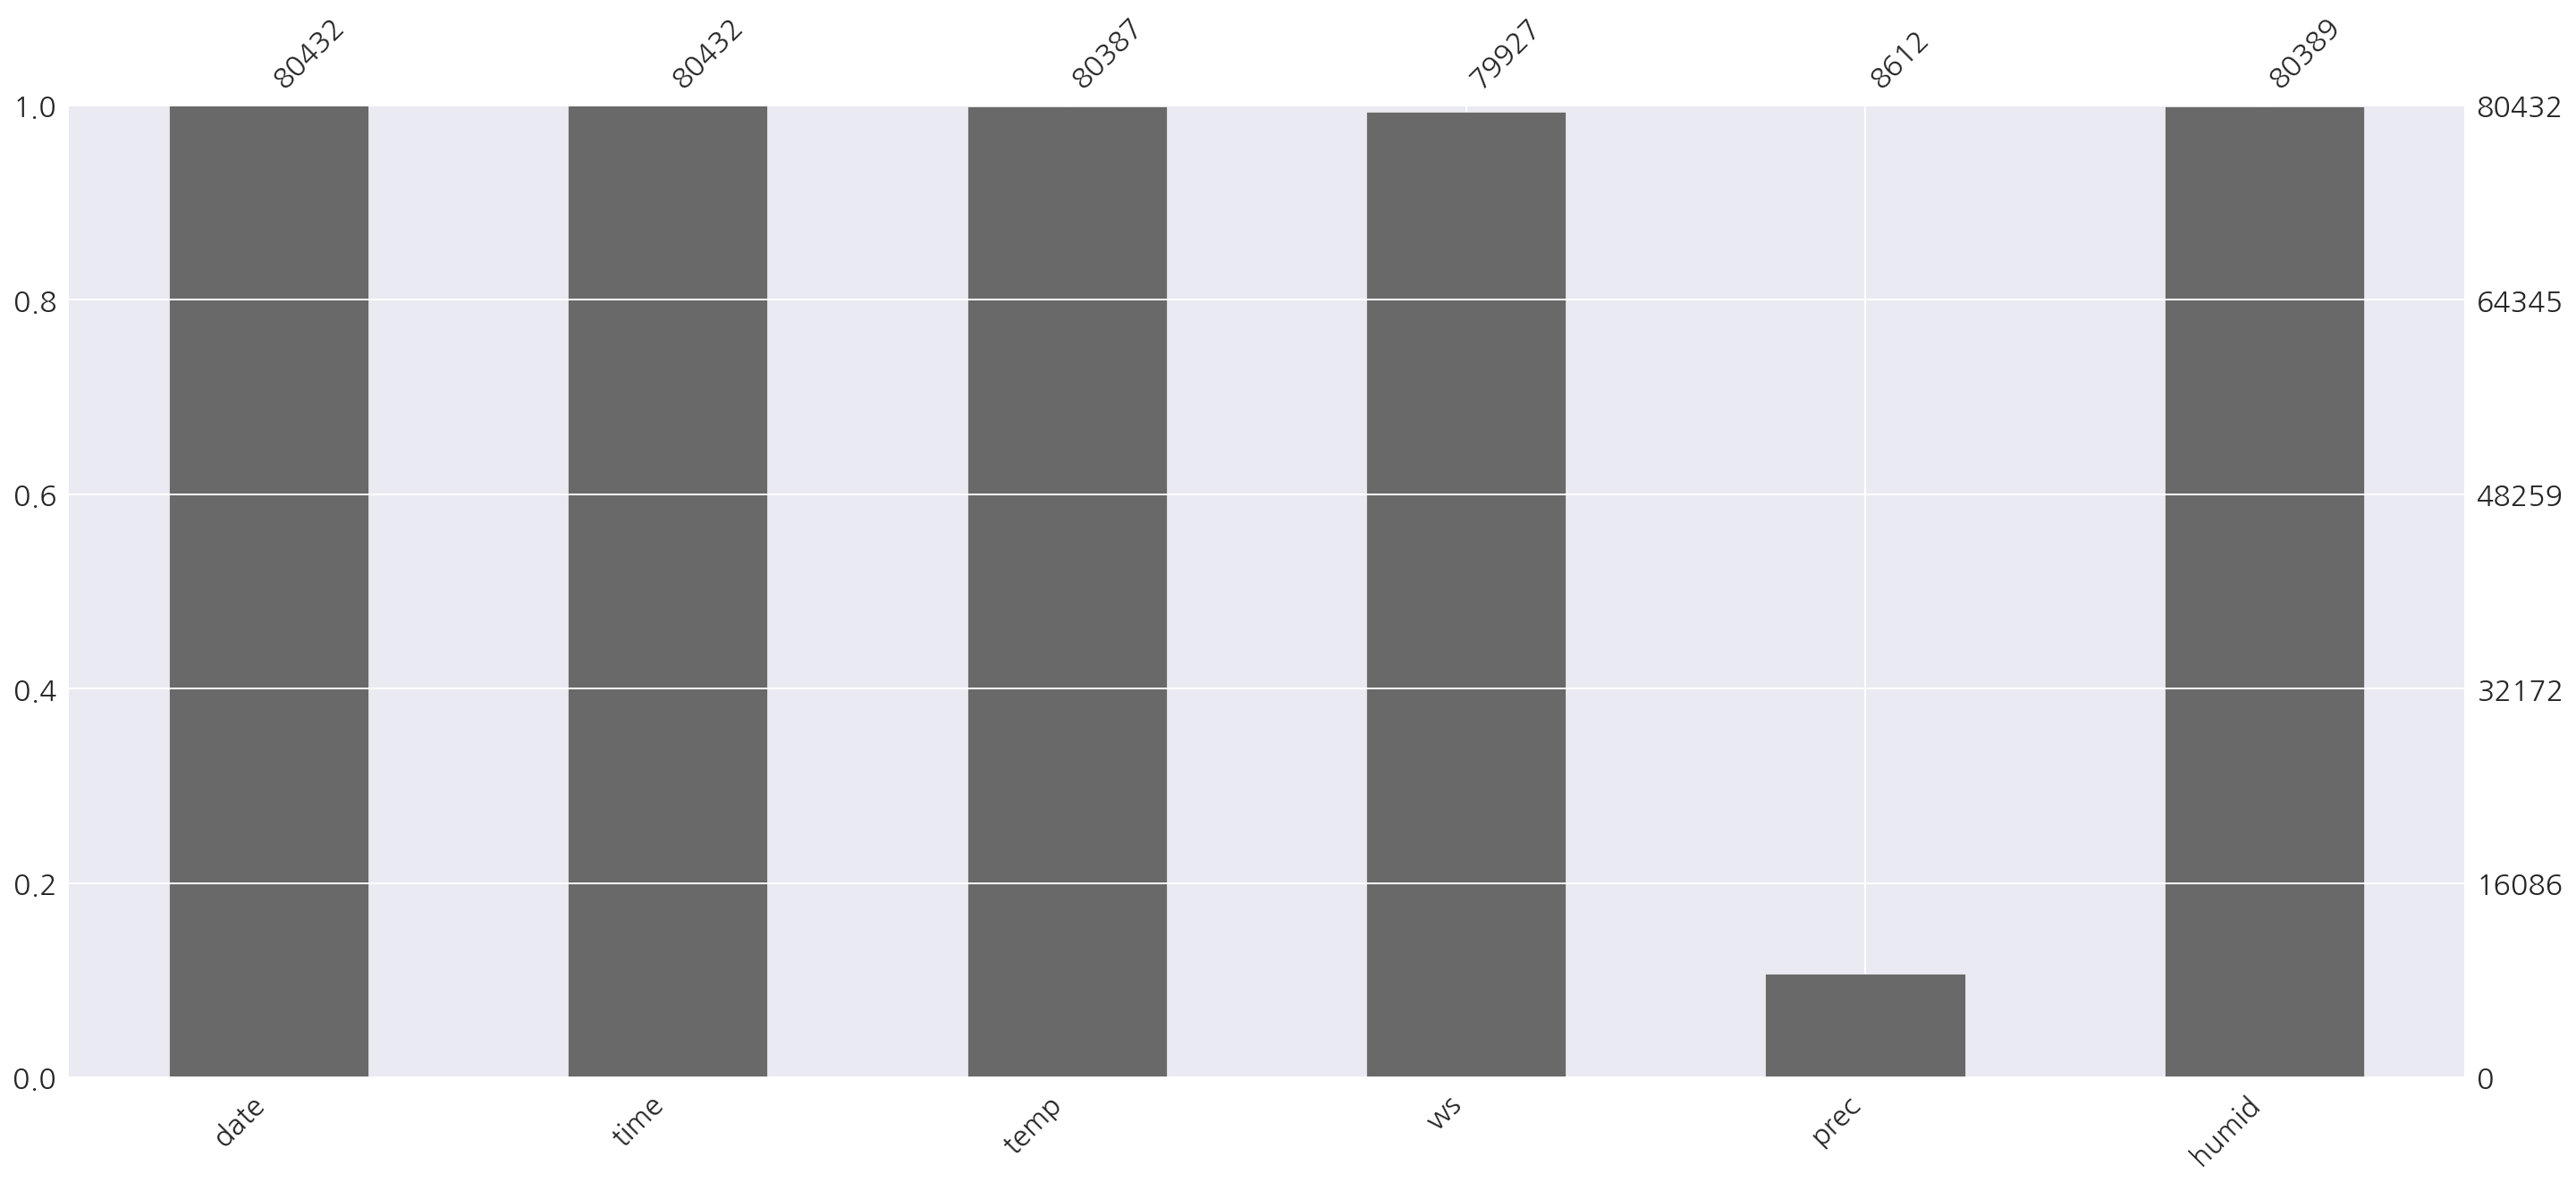

In [215]:
msno.bar(weather_useful)

##### 결측값을 채운후 결측값 확인
- 제주도 지하수정보 관리시스템에서 강수 정보 확인 결과 결측데이터를 0으로 처리하기로 함

In [216]:
#weather_full=weather_useful.fillna(method="bfill") - 0.793 
#weather_full = weather_useful.fillna(method = "pad") #- 0.796
weather_useful["prec"] = weather_useful["prec"].fillna(0)
weather_full = weather_useful.interpolate(method='values')  #0.908

In [217]:
weather_full.isnull().sum()

date     0
time     0
temp     0
ws       0
prec     0
humid    0
dtype: int64

In [241]:
# date의 자료형을 datetime으로 변환
weather_full['date'] = pd.to_datetime(weather_full['date'])

In [218]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80432 entries, 0 to 80431
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    80432 non-null  object 
 1   time    80432 non-null  object 
 2   temp    80432 non-null  float64
 3   ws      80432 non-null  float64
 4   prec    80432 non-null  float64
 5   humid   80432 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.3+ MB


##### 체감온도 및 불쾌지수 추가
- 불쾌지수
    - 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3
    
- 체감온도
    - 기상자료개방포털 자료 활용 (각 관측소 184(제주), 185(고산), 188(성산), 189(서귀포)에서 측정된 일간 체감온도)
        
- 자료 출처 : 체감온도 - 기상청, 불쾌지수 - 위키백과

In [219]:
# 불쾌지수 연산 함수
def discomfort_index(temp, rh):
    discomfort = round(0.81 * temp + 0.01 * rh * (0.99 * temp - 14.3) + 46.3, 1)
    return discomfort

In [220]:
# 불쾌지수 추가
weather_full["angry"] = discomfort_index(weather_full["temp"], weather_full["humid"])

In [221]:
# 시간별, 관측소별로 나눠진 데이터들을 일일 평균으로 하나의 데이터로 합침
weather_full = weather_full.groupby("date").mean().reset_index()

In [222]:
# 각 독립변수들의 값을 소수점 둘째자리에서 반올림
weather_full[["temp", "ws", "prec", "humid", "angry"]]= weather_full[["temp", "ws", "prec", "humid", "angry"]].round(1)

In [223]:
weather_full

,date,temp,ws,prec,humid,angry
0,2018-02-01,4.3,3.9,0.0,60.1,43.7
1,2018-02-02,3.8,4.3,0.0,55.3,43.5
2,2018-02-03,1.3,6.9,0.0,67.3,38.6
3,2018-02-04,-1.0,7.0,0.1,72.0,34.4
4,2018-02-05,-0.1,6.5,0.2,71.2,35.9
...,...,...,...,...,...,...
833,2020-05-14,18.7,2.7,0.0,56.3,63.7
834,2020-05-15,19.9,3.5,1.5,91.5,67.3
835,2020-05-16,17.6,2.0,0.2,96.6,63.5
836,2020-05-17,17.1,2.2,0.0,91.6,62.4


In [224]:
# 체감온도 추가
body_temp = pd.read_csv("body_temp.csv")
body_temp = body_temp.drop("Unnamed: 0", axis = 1)

In [225]:
body_temp

,date,temp,ws,body_temp,area
0,2018-02-01,4.7,4.0,1.9,184
1,2018-02-02,3.7,3.2,1.1,184
2,2018-02-03,1.7,6.0,-2.8,184
3,2018-02-04,-0.7,6.8,-6.1,184
4,2018-02-05,0.3,6.4,-4.7,184
...,...,...,...,...,...
3347,2020-05-14,19.1,0.8,19.1,189
3348,2020-05-15,19.8,1.4,19.8,189
3349,2020-05-16,18.4,0.9,18.4,189
3350,2020-05-17,17.6,1.0,17.6,189


In [229]:
# 4개의 관측소의 평균 일별 체감온도 컬럼 추가
weather_full["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)

In [230]:
weather_full

,date,temp,ws,prec,humid,angry,body_temp
0,2018-02-01,4.3,3.9,0.0,0.601,43.7,1.9
1,2018-02-02,3.8,4.3,0.0,0.553,43.5,1.0
2,2018-02-03,1.3,6.9,0.0,0.673,38.6,-2.8
3,2018-02-04,-1.0,7.0,0.1,0.720,34.4,-5.8
4,2018-02-05,-0.1,6.5,0.2,0.712,35.9,-4.3
...,...,...,...,...,...,...,...
833,2020-05-14,18.7,2.7,0.0,0.563,63.7,18.6
834,2020-05-15,19.9,3.5,1.5,0.915,67.3,19.8
835,2020-05-16,17.6,2.0,0.2,0.966,63.5,17.4
836,2020-05-17,17.1,2.2,0.0,0.916,62.4,17.0


##### 상대습도(humid) 변환
- humid : % -> /100

In [231]:
weather_full["humid"] = weather_full["humid"] / 100

In [232]:
weather_full

,date,temp,ws,prec,humid,angry,body_temp
0,2018-02-01,4.3,3.9,0.0,0.00601,43.7,1.9
1,2018-02-02,3.8,4.3,0.0,0.00553,43.5,1.0
2,2018-02-03,1.3,6.9,0.0,0.00673,38.6,-2.8
3,2018-02-04,-1.0,7.0,0.1,0.00720,34.4,-5.8
4,2018-02-05,-0.1,6.5,0.2,0.00712,35.9,-4.3
...,...,...,...,...,...,...,...
833,2020-05-14,18.7,2.7,0.0,0.00563,63.7,18.6
834,2020-05-15,19.9,3.5,1.5,0.00915,67.3,19.8
835,2020-05-16,17.6,2.0,0.2,0.00966,63.5,17.4
836,2020-05-17,17.1,2.2,0.0,0.00916,62.4,17.0


In [233]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       838 non-null    object 
 1   temp       838 non-null    float64
 2   ws         838 non-null    float64
 3   prec       838 non-null    float64
 4   humid      838 non-null    float64
 5   angry      838 non-null    float64
 6   body_temp  838 non-null    float64
dtypes: float64(6), object(1)
memory usage: 46.0+ KB


##### 관광객 데이터 불러오기
- datetime의 데이터 타입을 datetime형태로 형변환
- tour에서 ' , ' 를 제외하고 int형태로 형변환

In [234]:
tour_df = pd.read_csv("tour_stat.csv")
tour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  838 non-null    object
 1   tour      838 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


In [235]:
tour_df["datetime"]= pd.to_datetime(tour_df["datetime"])
tour_df = tour_df.rename(columns = {'datetime' : 'date'})

In [236]:
# , 제거 및 int형 형변환
tour_df["tour"] = tour_df["tour"].str.replace(",", "").astype(int)
tour_df

,date,tour
0,2018-02-01,33144
1,2018-02-02,31549
2,2018-02-03,31348
3,2018-02-04,26980
4,2018-02-05,30188
...,...,...
833,2020-05-14,23327
834,2020-05-15,22135
835,2020-05-16,23009
836,2020-05-17,24394


In [237]:
tour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    838 non-null    datetime64[ns]
 1   tour    838 non-null    int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 9.9 KB


##### target 데이터 불러오기
- 일별 최대 smp, 최소 smp, 평균 smp, 전력 수요량

In [238]:
# target 데이터 불러오기
target = pd.read_csv("target_v2.csv")
# target의 날짜 데이터의 자료형을 str -> datetime으로 변환
target['date'] = pd.to_datetime(target['date'])

In [239]:
# target 데이터프레임의 결측값 확인
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      838 non-null    datetime64[ns]
 1   smp_max   838 non-null    float64       
 2   smp_min   838 non-null    float64       
 3   smp_mean  838 non-null    float64       
 4   supply    838 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 32.9 KB


##### 날짜를 기준으로 날씨, 관광객, 타겟 데이터프레임 병합

In [242]:
# 날씨 데이터와 병합
target_v2 = target.merge(weather_full)
target_v2 = target_v2.merge(tour_df)

In [243]:
# 컬럼 재정렬
target_v2 = target_v2[["date", "smp_max", "smp_min", "smp_mean", "temp", "ws", "prec", "humid", "angry", "body_temp", "tour", "supply"]]
target_v2.head()

,date,smp_max,smp_min,smp_mean,temp,ws,prec,humid,angry,body_temp,tour,supply
0,2018-02-01,150.65,116.84,132.71,4.3,3.9,0.0,0.00601,43.7,1.9,33144,87.47
1,2018-02-02,163.86,116.84,134.19,3.8,4.3,0.0,0.00553,43.5,1.0,31549,86.64
2,2018-02-03,164.07,116.85,131.39,1.3,6.9,0.0,0.00673,38.6,-2.8,31348,88.28
3,2018-02-04,171.00,115.76,131.89,-1.0,7.0,0.1,0.00720,34.4,-5.8,26980,86.14
4,2018-02-05,170.34,123.89,137.96,-0.1,6.5,0.2,0.00712,35.9,-4.3,30188,90.63


In [244]:
target_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 0 to 837
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       838 non-null    datetime64[ns]
 1   smp_max    838 non-null    float64       
 2   smp_min    838 non-null    float64       
 3   smp_mean   838 non-null    float64       
 4   temp       838 non-null    float64       
 5   ws         838 non-null    float64       
 6   prec       838 non-null    float64       
 7   humid      838 non-null    float64       
 8   angry      838 non-null    float64       
 9   body_temp  838 non-null    float64       
 10  tour       838 non-null    int32         
 11  supply     838 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int32(1)
memory usage: 81.8 KB


##### 전체 기간에 대한 각 독립변수간의 상관관계 OLS

In [245]:
formula = ("supply ~ scale(smp_max) + scale(smp_min) + scale(smp_mean) +\
                            scale(temp) + scale(ws) + scale(prec) + scale(humid) + \
                            scale(angry) + scale(body_temp) + scale(tour)")

In [246]:
model1 = sm.OLS.from_formula(formula, data=target_v2)

In [247]:
result1 = model1.fit()

In [248]:
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 supply   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     123.2
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          2.47e-156
Time:                        13:22:15   Log-Likelihood:                -2627.3
No. Observations:                 838   AIC:                             5277.
Df Residuals:                     827   BIC:                             5329.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           74.2255      0.193  

##### PCA 분석

In [253]:
x = target_v2[["temp", "body_temp", "angry"]].values

pca = PCA(n_components = 2)
x_low = pca.fit_transform(x)

df_pca = pd.DataFrame(data = x_low, columns = ['pc1', 'pc2'])
df_pca.tail()

,pc1,pc2
833,-4.832391,-1.141121
834,-8.609103,0.058706
835,-3.565785,-0.174850
836,-2.333240,-0.492178
837,-7.130725,0.001296


In [254]:
target_v2["pc1"], target_v2["pc2"] = df_pca["pc1"], df_pca["pc2"]
target_v2.tail()

,date,smp_max,smp_min,smp_mean,temp,ws,prec,humid,angry,body_temp,tour,supply,pc1,pc2
833,2020-05-14,193.28,66.78,100.46,18.7,2.7,0.0,0.00563,63.7,18.6,23327,62.70,-4.832391,-1.141121
834,2020-05-15,198.23,61.81,102.38,19.9,3.5,1.5,0.00915,67.3,19.8,22135,64.91,-8.609103,0.058706
835,2020-05-16,220.91,88.50,121.19,17.6,2.0,0.2,0.00966,63.5,17.4,23009,61.75,-3.565785,-0.174850
836,2020-05-17,207.75,65.78,116.82,17.1,2.2,0.0,0.00916,62.4,17.0,24394,61.55,-2.333240,-0.492178
837,2020-05-18,113.31,66.86,98.98,19.2,3.1,0.4,0.00921,66.2,19.1,24001,63.91,-7.130725,0.001296


#### PCA 성분 추가한 OLS 분석

In [301]:
formula_pca = ("scale(supply) ~ scale(smp_max) + scale(smp_min) + scale(smp_mean) +\
                            scale(ws) + scale(prec) + scale(humid) + \
                            scale(pc1) + scale(pc2) + scale(tour) + I(scale(temp)*scale(pc1))")

In [302]:
model2 = sm.OLS.from_formula(formula_pca, data=target_v2)
result2 = model2.fit()

In [303]:
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     242.8
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          3.29e-238
Time:                        13:51:44   Log-Likelihood:                -614.93
No. Observations:                 838   AIC:                             1252.
Df Residuals:                     827   BIC:                             1304.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### 일별 전력 수요와 온도 그래프 시각화
- 온도와 전력 수요의 일별 변화 추이를 보기위해 RobustScaler 스케일 기법사용

In [334]:
scaler = RobustScaler()
data_scale = pd.DataFrame(scaler.fit_transform(target_v2[["temp", "supply"]]), columns = ["temp", "supply"])
data_scale

,temp,supply
0,-1.026786,0.982741
1,-1.071429,0.925440
2,-1.294643,1.038661
3,-1.500000,0.890922
4,-1.419643,1.200897
...,...,...
833,0.258929,-0.727304
834,0.366071,-0.574732
835,0.160714,-0.792889
836,0.116071,-0.806697


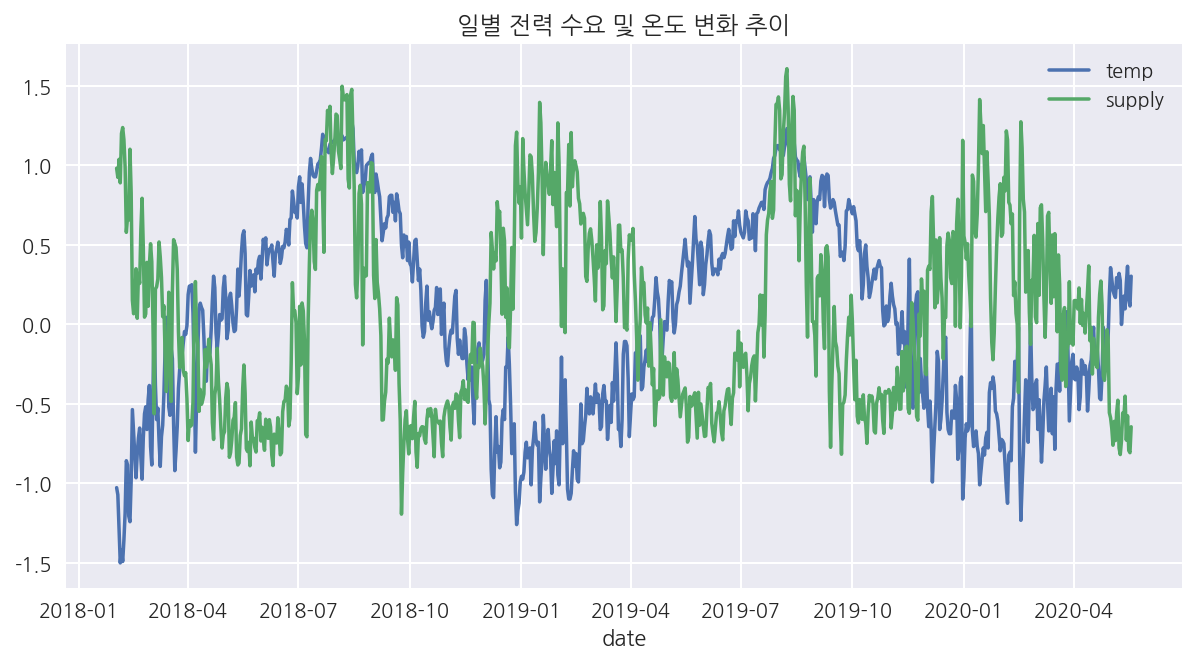

In [335]:
plt.figure(figsize=(10, 5), facecolor="1.")
plt.title("일별 전력 수요 및 온도 변화 추이")
plt.plot(target_v2["date"], data_scale["temp"], label = 'temp')
plt.plot(target_v2["date"], data_scale["supply"], label = 'supply')
plt.xlabel('date')
plt.legend()
plt.show()

##### 냉방기와 난방기를 나눠서 OLS분석
- 냉방기 : 5월 ~ 10월
- 난방기 : 11월 ~ 4월

In [304]:
# 냉방기 기간 : 5월 ~10월
summer = np.logical_and((pd.DatetimeIndex(target_v2["date"]).month >= 5),\
                        (pd.DatetimeIndex(target_v2["date"]).month < 11))
# 난방기 기간 : 11월 ~ 4월
winter = np.invert(summer)

##### 냉방기 OLS

In [305]:
target_summer = target_v2[summer]

In [306]:
model_summer = sm.OLS.from_formula(formula_pca, data=target_summer)

In [307]:
result_summer = model_summer.fit()

In [308]:
print(result_summer.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     523.4
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          2.12e-213
Time:                        13:51:50   Log-Likelihood:                -25.600
No. Observations:                 386   AIC:                             73.20
Df Residuals:                     375   BIC:                             116.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

##### 난방기 OLS

In [309]:
target_winter = target_v2[winter]

In [310]:
model_winter = sm.OLS.from_formula(formula_pca, data=target_winter)

In [311]:
result_winter = model_winter.fit()

In [312]:
print(result_winter.summary())

                            OLS Regression Results                            
Dep. Variable:          scale(supply)   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     204.3
Date:                Wed, 17 Jun 2020   Prob (F-statistic):          1.37e-158
Time:                        13:51:52   Log-Likelihood:                -250.69
No. Observations:                 452   AIC:                             523.4
Df Residuals:                     441   BIC:                             568.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

##### 공휴일
- 한국 법령 관공서의 공휴일에 관한 규정에 지정된 공휴일들만 취급
- 새해, 설날(전날, 당일, 다음날), 삼일절, 어린이날, 

In [338]:
pd.read_csv("holidaylist.csv", encoding = 'ISO-8859-1')

,³¯Â¥,¿äÀÏ,°øÈÞÀÏ
0,2018-01-01,¿ù¿äÀÏ,»õÇØ
1,2018-02-15,¸ñ¿äÀÏ,¼³³¯
2,2018-02-16,±Ý¿äÀÏ,¼³³¯
3,2018-02-17,Åä¿äÀÏ,¼³³¯
4,2018-03-01,¸ñ¿äÀÏ,»ïÀÏÀý
5,2018-05-05,Åä¿äÀÏ,¾î¸°ÀÌ³¯
6,2018-05-22,È­¿äÀÏ,ºÎÃ³´Ô¿À½Å³¯
7,2018-06-06,¼ö¿äÀÏ,ÇöÃæÀÏ
8,2018-08-15,¼ö¿äÀÏ,±¤º¹Àý
9,2018-09-23,ÀÏ¿äÀÏ,Ãß¼®
